# Chapter 3: Fractal Basin Boundaries and Chaotic Attractors
*Based on K. T. Alligood and J. A. Yorke*

## Summary

When a system has multiple attractors, the boundary between their basins of attraction can be fractal. Key concepts:

- **Basins of attraction**: Sets of initial conditions leading to a given attractor
- **Fractal basin boundaries**: Infinitely complex boundaries between basins
- **Riddled basins**: Basins with fractal measure-zero holes
- **Final state sensitivity**: Small changes in initial conditions lead to different attractors
- **The Wada property**: Three or more basins sharing a common boundary

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from ipywidgets import interact, IntSlider, FloatSlider
%matplotlib inline
plt.style.use('dark_background')

## 3.1 Newton's Method Basin Boundaries

Newton's method for finding roots of $z^3 - 1 = 0$ has three attracting fixed points. The basin boundaries form a fractal.

In [3]:
@jit(nopython=True)
def newton_basins(xmin, xmax, ymin, ymax, resolution, max_iter):
    """Compute Newton fractal for z^3 - 1"""
    # Roots of z^3 - 1
    roots = np.array([1.0 + 0j, 
                      -0.5 + 0.866025j, 
                      -0.5 - 0.866025j])
    
    basins = np.zeros((resolution, resolution), dtype=np.int32)
    
    for i in range(resolution):
        for j in range(resolution):
            x = xmin + (xmax - xmin) * j / resolution
            y = ymin + (ymax - ymin) * i / resolution
            z = complex(x, y)
            
            for _ in range(max_iter):
                if abs(z) < 1e-10:
                    break
                # Newton iteration: z - f(z)/f'(z) = z - (z^3-1)/(3z^2)
                z = z - (z**3 - 1) / (3 * z**2)
            
            # Determine which root we converged to
            min_dist = 1e10
            basin = 0
            for k in range(3):
                dist = abs(z - roots[k])
                if dist < min_dist:
                    min_dist = dist
                    basin = k + 1
            
            basins[resolution - 1 - i, j] = basin
    
    return basins

def plot_newton_basins(zoom=1.0, center_x=0.0, center_y=0.0, resolution=500):
    """Plot Newton fractal basins"""
    half_width = 2.0 / zoom
    xmin, xmax = center_x - half_width, center_x + half_width
    ymin, ymax = center_y - half_width, center_y + half_width
    
    basins = newton_basins(xmin, xmax, ymin, ymax, resolution, 50)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = ['black', '#ff6b6b', '#4ecdc4', '#ffe66d']
    cmap = plt.matplotlib.colors.ListedColormap(colors)
    
    ax.imshow(basins, extent=[xmin, xmax, ymin, ymax], cmap=cmap)
    ax.set_xlabel('Re(z)')
    ax.set_ylabel('Im(z)')
    ax.set_title('Newton Fractal: Basins for $z^3 - 1 = 0$')
    plt.show()

interact(plot_newton_basins,
         zoom=FloatSlider(min=1, max=50, step=1, value=1, description='Zoom'),
         center_x=FloatSlider(min=-2, max=2, step=0.1, value=0, description='Center X'),
         center_y=FloatSlider(min=-2, max=2, step=0.1, value=0, description='Center Y'));

interactive(children=(FloatSlider(value=1.0, description='Zoom', max=50.0, min=1.0, step=1.0), FloatSlider(val…

## 3.2 Forced Damped Pendulum

A driven pendulum can have multiple coexisting attractors with fractal basin boundaries.

TEST
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


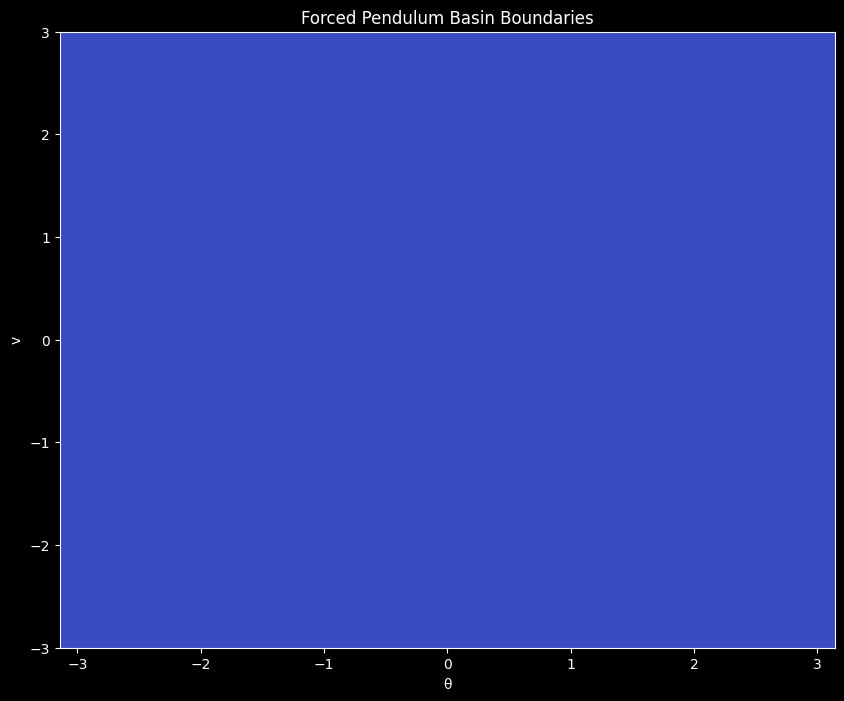

In [5]:
# I Think this one is broken and it takes forever

from scipy.integrate import odeint

def pendulum_basins(resolution=200):
    """Compute basin of attraction for forced pendulum"""
    gamma, omega, b = 1.5, 0.666, 0.75  # Forcing amplitude, frequency, damping
    
    def pendulum(y, t):
        theta, v = y
        return [v, -b*v - np.sin(theta) + gamma*np.cos(omega*t)]
    
    theta_range = np.linspace(-np.pi, np.pi, resolution)
    v_range = np.linspace(-3, 3, resolution)
    basins = np.zeros((resolution, resolution))
    
    t = np.linspace(0, 200, 2000)
    
    for i, v0 in enumerate(v_range[::-1]):
        for j, theta0 in enumerate(theta_range):
            sol = odeint(pendulum, [theta0, v0], t)
            final_theta = sol[-1, 0] % (2*np.pi)
            if final_theta > np.pi:
                final_theta -= 2*np.pi
            # Classify by final state
            basins[i, j] = np.sign(final_theta)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(basins, extent=[-np.pi, np.pi, -3, 3], 
              cmap='coolwarm', aspect='auto')
    ax.set_xlabel('θ')
    ax.set_ylabel('v')
    ax.set_title('Forced Pendulum Basin Boundaries')
    plt.show()

pendulum_basins()

## 3.3 Magnetic Pendulum

A pendulum over three magnets has three basins with fractal boundaries.

In [6]:
@jit(nopython=True)
def magnetic_pendulum_basin(x0, y0, magnets, friction, height, max_iter):
    """Simulate magnetic pendulum and return which magnet it settles near"""
    x, y = x0, y0
    vx, vy = 0.0, 0.0
    dt = 0.02
    
    for _ in range(max_iter):
        # Forces from magnets
        fx, fy = 0.0, 0.0
        for k in range(3):
            mx, my = magnets[k, 0], magnets[k, 1]
            dx, dy = mx - x, my - y
            r = np.sqrt(dx**2 + dy**2 + height**2)
            f = 1.0 / (r**3)
            fx += f * dx
            fy += f * dy
        
        # Restoring force (gravity/spring)
        fx -= 0.2 * x
        fy -= 0.2 * y
        
        # Friction
        fx -= friction * vx
        fy -= friction * vy
        
        # Update velocity and position
        vx += fx * dt
        vy += fy * dt
        x += vx * dt
        y += vy * dt
        
        # Check if settled
        if vx**2 + vy**2 < 1e-6:
            break
    
    # Determine nearest magnet
    min_dist = 1e10
    nearest = 0
    for k in range(3):
        dist = (x - magnets[k, 0])**2 + (y - magnets[k, 1])**2
        if dist < min_dist:
            min_dist = dist
            nearest = k
    
    return nearest

def plot_magnetic_basins(resolution=300, friction=0.2, height=0.5):
    """Plot magnetic pendulum basins"""
    # Three magnets at vertices of equilateral triangle
    magnets = np.array([[1.0, 0.0],
                        [-0.5, 0.866],
                        [-0.5, -0.866]])
    
    basins = np.zeros((resolution, resolution))
    x_range = np.linspace(-2, 2, resolution)
    y_range = np.linspace(-2, 2, resolution)
    
    for i, y in enumerate(y_range[::-1]):
        for j, x in enumerate(x_range):
            basins[i, j] = magnetic_pendulum_basin(x, y, magnets, friction, height, 5000)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = ['#ff6b6b', '#4ecdc4', '#ffe66d']
    cmap = plt.matplotlib.colors.ListedColormap(colors)
    
    ax.imshow(basins, extent=[-2, 2, -2, 2], cmap=cmap)
    
    # Mark magnet positions
    for k, (mx, my) in enumerate(magnets):
        ax.plot(mx, my, 'wo', ms=10, mew=2)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Magnetic Pendulum Basin Boundaries')
    plt.show()

interact(plot_magnetic_basins,
         friction=FloatSlider(min=0.1, max=0.5, step=0.05, value=0.2, description='Friction'),
         height=FloatSlider(min=0.2, max=1.0, step=0.1, value=0.5, description='Height'));

interactive(children=(IntSlider(value=300, description='resolution', max=900, min=-300), FloatSlider(value=0.2…

## Notes

- **Uncertainty exponent**: Quantifies how the probability of prediction error scales with measurement precision
- **Wada basins**: Named after mathematician Takeo Wada; every boundary point is on the boundary of all basins
- **Practical implications**: Fractal basin boundaries make long-term prediction impossible even without chaos in the attractor itself